In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import figures as f

#import os
#os.environ['pRT_input_data_path'] = '/home/sdregt/new_retrieval_venv/pRT_input_data'
#os.environ['LD_LIBRARY_PATH'] = '/home/sdregt/new_retrieval_venv/MultiNest/lib'

import retrieval_base.auxiliary_functions as af
import pymultinest
import json
import copy

from tqdm import tqdm

import petitRADTRANS.nat_cst as nc

from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

In [2]:
import numpy as np
from scipy.special import lambertw as W
from scipy.special import erfcinv

def Z_to_sigma(ln_Z1, ln_Z2):
    '''Convert log-evidences of two models to a sigma confidence level'''
    B = np.exp(ln_Z1 - ln_Z2)
    p = np.real(np.exp(W((-1.0/(B*np.exp(1))),-1)))
    sigma = np.sqrt(2)*erfcinv(p)

    print('ln B: {:.2f} | sigma: {:.2f}'.format(ln_Z1-ln_Z2, sigma))
    return B, sigma

In [3]:
def read_results(prefix, n_params, m_set='K2166_cloudy', w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()
    ln_Z = stats['nested importance sampling global log-evidence']

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+f'data/bestfit_PT_{m_set}.pkl')
    Chem = af.pickle_load(prefix+f'data/bestfit_Chem_{m_set}.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{m_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    try:
        LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{m_set}.pkl')
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{m_set}.pkl')
    except FileNotFoundError:
        LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike.pkl')
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov.pkl')

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{m_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{m_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{m_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    return ln_Z, posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

#prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_4/test_'
#prefix_no_band = './retrieval_outputs/no_bands_K_A_ret_2/test_'
#prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_6/test_'
#res = read_results(prefix=prefix_no_band, n_params=27)
prefix_no_band = './retrieval_outputs/eq_band_K_B_ret_2/test_'
res = read_results(prefix=prefix_no_band, n_params=28)

#prefix_no_band = './retrieval_outputs/spot_eq_band_K_B_ret_11/test_'
#res = read_results(prefix=prefix_no_band, n_params=35)
#prefix_no_band = './retrieval_outputs/spot_eq_band_K_B_ret_12/test_'
#res = read_results(prefix=prefix_no_band, n_params=38)
ln_Z_no_band, _, _, PT_no_band, Chem_no_band, _, _, _, m_spec_no_band, d_spec, LogLike_no_band, Cov_no_band, bestfit_params_no_band = res
del res

#prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_1/test_'
#prefix_eq_band = './retrieval_outputs/eq_band_K_A_ret_3/test_'
#prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_2/test_'
#res = read_results(prefix=prefix_eq_band, n_params=28)
#prefix_eq_band = './retrieval_outputs/spot_eq_band_K_B_ret_14/test_'
prefix_eq_band = './retrieval_outputs/spot_K_B_ret_19/test_'
res = read_results(prefix=prefix_eq_band, n_params=36)
ln_Z_eq_band, _, _, PT_eq_band, Chem_eq_band, _, _, _, m_spec_eq_band, d_spec, LogLike_eq_band, Cov_eq_band, bestfit_params_eq_band = res
del res

_ = Z_to_sigma(ln_Z_eq_band, ln_Z_no_band)
_ = Z_to_sigma(ln_Z_no_band, ln_Z_eq_band)

  analysing data from ./retrieval_outputs/eq_band_K_B_ret_2/test_.txt
  analysing data from ./retrieval_outputs/spot_K_B_ret_19/test_.txt
ln B: -11491.40 | sigma: nan
ln B: 11491.40 | sigma: inf


/tmp/ipykernel_69236/1782613870.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  p = np.real(np.exp(W((-1.0/(B*np.exp(1))),-1)))
/tmp/ipykernel_69236/1782613870.py:7: RuntimeWarning: overflow encountered in exp
  B = np.exp(ln_Z1 - ln_Z2)


In [5]:
def get_pRT_atm(prefix, bestfit_params, Chem, PT, m_set='K2166_cloudy', vsini_local=0, line_species=None):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{m_set}.pkl')

    if not hasattr(pRT_atm, 'sum_m_spec'):
        pRT_atm.sum_m_spec = False

    # Compute global model spectrum
    params_global = copy.deepcopy(bestfit_params['params'][m_set])
    no_bands = prefix.split('retrieval_outputs/')[-1].startswith('no_bands')
    if no_bands:
        params_global['lat_band'] = None
    pRT_atm.params = params_global

    Chem.mass_fractions['HCN_main_iso'] = 0*Chem.mass_fractions['H2O_pokazatel_main_iso']

    m_spec_global = pRT_atm(Chem.mass_fractions, PT.temperature, params_global, get_contr=False, get_full_spectrum=True)
    m_spec_global.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_global.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    Rot = copy.copy(pRT_atm.Rot)

    # Compute local model spectrum
    params_local = copy.deepcopy(params_global)
    params_local['vsini'] = vsini_local
    params_local['lat_band'] = None
    params_local['lat_band_upper'] = 90
    params_local['epsilon_band'] = 1
    pRT_atm.params = params_local

    # Local abundances
    mf_local = Chem.mass_fractions.copy()
    if line_species is not None:
        
        for key_i in mf_local.keys():
            # Set abundances of other species to 0
            if key_i != line_species:
                mf_local[key_i] *= 0

    m_spec_local = pRT_atm(mf_local, PT.temperature, params_local, get_contr=False, get_full_spectrum=True)
    m_spec_local.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_local.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    return m_spec_global, m_spec_local, Rot

m_spec_global_no_band, m_spec_local_no_band, Rot_no_band = get_pRT_atm(
    prefix_no_band, bestfit_params_no_band, copy.deepcopy(Chem_no_band), PT_no_band
    #prefix_no_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band
    )
m_spec_global_eq_band, m_spec_local_eq_band, Rot_eq_band = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band
    )

#'''
_, _, Rot_spot = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band, m_set='K2166_spot'
    )
Rot_eq_band.int_flux[Rot_spot.included_segments] = Rot_spot.int_flux[Rot_spot.included_segments]
#'''

AttributeError: 'pRT_model' object has no attribute 'wave_pRT_grid'

In [ ]:
def get_CCF(
    d_spec, 
    m_spec_local, 
    m_spec_global, 
    LogLike, 
    Cov, 
    #rv=np.arange(-200,200+1e-6,1), 
    rv=np.arange(-200,200+1e-6,0.5), 
    filter_width=50, 
    subtract_global_from_template=False
    ):

    CCF = np.nan * np.ones(
        (len(rv), d_spec.n_orders, d_spec.n_dets)
        )
    
    d_wave = np.copy(d_spec.wave)
    d_res  = np.copy(d_spec.flux) - np.copy(LogLike.m_flux_phi)
    mask = d_spec.mask_isfinite

    # Apply high-pass filter to the residuals
    '''
    lp_d_res = np.nan*np.ones_like(d_res)
    lp_d_res[mask] = gaussian_filter1d(
        d_res[mask], sigma=filter_width, axis=-1, mode='nearest'
        )
    '''
    lp_d_res = np.zeros_like(d_res) # If data is already high-pass filtered
    d_res -= lp_d_res

    for i, rv_i in enumerate(tqdm(rv)):

        for j in range(d_spec.n_orders):
            
            # Shift the model spectrum
            m_wave_local = np.copy(m_spec_local.wave_pRT_grid[j])
            m_wave_local *= (1 + rv_i/(nc.c*1e-5))

            m_flux_local = np.copy(m_spec_local.flux_pRT_grid[j])

            for k in range(d_spec.n_dets):

                # Don't consider the nans
                mask_jk = d_spec.mask_isfinite[j,k]

                if not mask_jk.any():
                    continue

                # Subtract the global model?
                if subtract_global_from_template:
                    m_res_local_jk = m_flux_local - m_spec_global.flux_pRT_grid[j]
                else:
                    m_res_local_jk = m_flux_local
                
                # Interpolate onto the data wavelength grid
                m_res_local_jk = np.interp(
                    d_wave[j,k], xp=m_wave_local, fp=m_res_local_jk
                    )
                m_res_local_jk *= LogLike.phi[j,k,0]

                # Apply high-pass filter to the model too
                '''
                lp_m_res_local_jk = np.nan*np.ones_like(m_res_local_jk)
                lp_m_res_local_jk[mask_jk] = gaussian_filter1d(
                    m_res_local_jk[mask_jk], sigma=filter_width, axis=-1, mode='nearest'
                    )
                m_res_local_jk -= lp_m_res_local_jk
                '''

                lp_m_res_local_jk = np.nan*np.ones_like(m_res_local_jk)
                lp_m_res_local_jk[mask_jk] = savgol_filter(
                    m_res_local_jk[mask_jk], window_length=301, polyorder=2, mode='nearest', 
                    )
                m_res_local_jk -= lp_m_res_local_jk

                # Compute the cross-correlation coefficient
                CCF[i,j,k] = np.dot(
                    m_res_local_jk[mask_jk], LogLike.s2[j,k]**(-1) * Cov[j,k].solve(d_res[j,k,mask_jk])
                    )
    
    return CCF, rv

def CCF_to_SNR(rv, CCF, rv_sep=75):

    rv_mask = np.abs(rv) > rv_sep

    mean_CCF = np.mean(CCF[rv_mask])
    std_CCF  = np.std(CCF[rv_mask])

    return (CCF - mean_CCF) / std_CCF

CCF_no_band, rv = get_CCF(
    d_spec, m_spec_local_no_band, m_spec_global_no_band, LogLike_no_band, Cov_no_band, 
    subtract_global_from_template=True, 
    )
CCF_eq_band, rv = get_CCF(
    d_spec, m_spec_local_eq_band, m_spec_global_eq_band, LogLike_eq_band, Cov_eq_band, 
    subtract_global_from_template=True, 
    )

100%|██████████| 801/801 [00:03<00:00, 255.69it/s]


In [ ]:
#vsini_no_band = bestfit_params_no_band['params']['K2166_A']['vsini']
vsini_no_band = bestfit_params_no_band['params']['K2166_cloudy']['vsini']
#vsini_eq_band = bestfit_params_eq_band['params']['K2166_A']['vsini']
vsini_eq_band = bestfit_params_eq_band['params']['K2166_cloudy']['vsini']

(1, 256)
(1, 256)
(1, 256)
(1, 256)


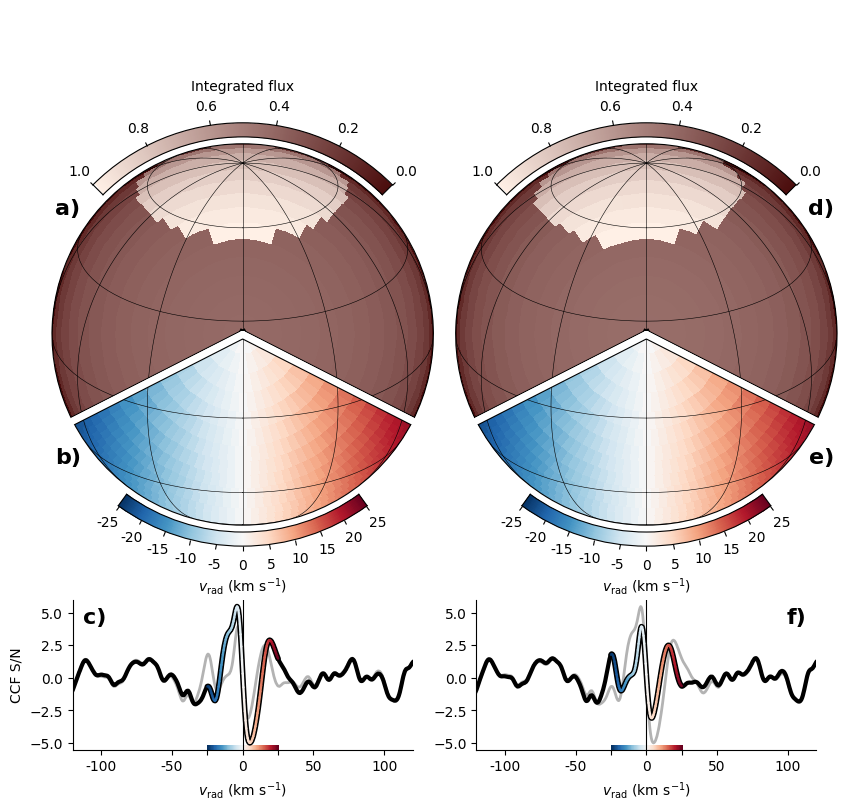

In [ ]:
'''
lat_spot = np.deg2rad(11)
lon_spot = np.deg2rad(-71)
radius_spot = np.deg2rad(20)

# Haversine formula
distance_from_spot = 2 * np.arcsin((1/2*(
    1 - np.cos((Rot_no_band.lat_grid - lat_spot)) + \
    np.cos(lat_spot)*np.cos(Rot_no_band.lat_grid)*(1-np.cos((Rot_no_band.lon_grid-lon_spot)))
    ))**(1/2))
Rot_no_band.mask_patch = (distance_from_spot <= radius_spot)

a, b = np.deg2rad(42), np.deg2rad(7)

dist_lon = np.abs(Rot_no_band.lon_grid - lon_spot)
dist_lon[(dist_lon > np.pi)] = np.pi - dist_lon[(dist_lon > np.pi)] % np.pi

dist_lat = np.abs(Rot_no_band.lat_grid - lat_spot)
Rot_no_band.mask_patch = ((dist_lon/a)**2 + (dist_lat/b)**2 <= 1)
#Rot_no_band.mask_patch = dist_lat
'''

cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#4A0C0C','#fff0e6'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#6C0000','#fff0e6'])
cmap.set_bad('w')
cmap.set_over('w')
cmap.set_under('k')

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0, wspace=0.02)#, height_ratios=[0.1,0.8,0.1])

ax  = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

cax = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

vmin, vmax = np.nanmin(Rot_no_band.int_flux), np.nanmax(Rot_no_band.int_flux)
#vmin, vmax = np.nanmin(Rot_eq_band.int_flux), np.nanmax(Rot_eq_band.int_flux)
#vmin, vmax = 0, 1
f.plot_map(ax[0], 'int_flux', Rot_no_band, cmap=cmap, vmin=vmin, vmax=vmax, 
    edgecolors='face', lw=1e-6
    )
#f.plot_map(ax[0], 'mask_patch', Rot_no_band, cmap='viridis', vmin=0, vmax=Rot_no_band.mask_patch.max(), 
#    edgecolors='face', lw=1e-6
#    )

#vmin, vmax = Rot_no_band.v_grid.min(), Rot_no_band.v_grid.max()
vmin, vmax = -vsini_no_band, vsini_no_band
f.plot_map(ax[1], 'v_grid', Rot_no_band, cmap='RdBu_r', vmin=vmin, vmax=vmax, 
    edgecolors='face', lw=1e-6
    )

vmin, vmax = np.nanmin(Rot_eq_band.int_flux[Rot_eq_band.included_segments]), \
    np.nanmax(Rot_eq_band.int_flux[Rot_eq_band.included_segments])
#vmin, vmax = 0, 1
f.plot_map(ax[2], 'int_flux', Rot_eq_band, cmap=cmap, vmin=vmin, vmax=vmax, 
    edgecolors='face', lw=1e-6
    )

#vmin, vmax = Rot_eq_band.v_grid.min(), Rot_eq_band.v_grid.max()
vmin, vmax = -vsini_eq_band, vsini_eq_band
f.plot_map(ax[3], 'v_grid', Rot_eq_band, cmap='RdBu_r', vmin=vmin, vmax=vmax, 
    edgecolors='face', lw=1e-6
    )

for i, (ax_i, Rot_i, theta_cen_i, theta_width_i) in enumerate(zip(
        ax, [Rot_no_band,Rot_no_band,Rot_eq_band,Rot_eq_band],
        #np.array([1,-1,1,-1])*np.pi/2, np.array([1.2,2-1.2,1.2,2-1.2])*np.pi
        np.array([1,-1,1,-1])*np.pi/2, np.array([1.3,2-1.3,1.3,2-1.3])*np.pi
        #np.array([1,-1,1,-1])*np.pi/2, np.array([1.99,2-1.99,1.99,2-1.99])*np.pi
        )):

    f.set_thetalim(ax_i, theta_cen_i, theta_width_i)
    f.set_axis(ax_i, Rot_i, sep_spine_lw=5)

    wspace = 0
    if i >= 2:
        wspace = gs.wspace
    f.rescale_and_center(fig, ax_i, ax[0], x_offset=wspace)

int_flux_values = np.arange(0,1+1e-6,0.2).round(1)
vsini_values  = np.arange(-25,+25+1e-6,5,dtype=int)

int_flux_range = (0,1)

int_flux_ann_kwargs = dict(xycoords='axes fraction', ha='center', va='bottom', xy=(0.5,1-0.28))
vsini_ann_kwargs  = dict(xycoords='axes fraction', ha='center', va='top', xy=(0.5,0.28))

for i, (cax_i, cmap_i) in enumerate(zip(cax, [cmap,'RdBu_r',cmap,'RdBu_r'])):

    theta_lim = [
        (1/4*np.pi,3/4*np.pi),(-np.pi/2-np.pi/5,-np.pi/2+np.pi/5),
        (1/4*np.pi,3/4*np.pi),(-np.pi/2-np.pi/5,-np.pi/2+np.pi/5)
        ][i]
    
    f.set_cb_axis(cax_i, theta_lim, cmap_i, r_origin=-14)

    ax_ref = [ax[0],ax[0],ax[2],ax[3]][i]

    f.rescale_and_center(fig, cax_i, ax_ref, coord_min=(0,-14), scale=1.11)

    ticks = [int_flux_values,vsini_values,int_flux_values,vsini_values][i]
    val_range = [
        int_flux_range,(-vsini_no_band,vsini_no_band),int_flux_range,(-vsini_eq_band,vsini_eq_band)
        ][i]
    #label = [r'$\xi$',r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$',r'$\xi$',r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$'][i]
    label = [
        r'Integrated flux', 
        r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$',
        r'Integrated flux',
        r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$'
        ][i]
    ann_kwargs = [int_flux_ann_kwargs,vsini_ann_kwargs,int_flux_ann_kwargs,vsini_ann_kwargs][i]

    f.label_cb_axis(cax_i, ticks, val_range, label, ann_kwargs)

ax_CCF = []
for i, ax_ref in enumerate([ax[1],ax[3]]):
    l, b, w, h = ax_ref.get_position().bounds
    ax_CCF_dim = [l, b-0.3, w, 0.3]

    sharey = None
    if i == 1:
        sharey = ax_CCF[-1]
    
    ax_CCF.append(fig.add_axes(ax_CCF_dim, sharey=sharey))

Z = np.linspace(0,1+1e-6,50).reshape(-1,1).T
gradient_kwargs = dict(
    cmap='RdBu_r', vmin=0, vmax=1, origin='lower', aspect='auto', zorder=-1, 
    )
ax_CCF[0].imshow(
    Z, extent=[-vsini_no_band, vsini_no_band, 0, 0.03], 
    transform=ax_CCF[0].get_xaxis_transform(), **gradient_kwargs
    )

Z = np.linspace(0,1+1e-6,50).reshape(-1,1).T
gradient_kwargs = dict(
    cmap='RdBu_r', vmin=0, vmax=1, origin='lower', aspect='auto', zorder=-1, 
    )
ax_CCF[1].imshow(
    Z, extent=[-vsini_eq_band, vsini_eq_band, 0, 0.03], 
    transform=ax_CCF[1].get_xaxis_transform(), **gradient_kwargs
    )

ax_CCF[0].plot(rv, CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2))), c='0.7', lw=2)
ax_CCF[0].plot(rv, CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2))), c='k', lw=3)
rv_mask = (np.abs(rv) < vsini_eq_band)
ax_CCF[0].plot(
    rv[rv_mask], CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2)))[rv_mask], c='k', lw=4, solid_capstyle='round'
    )
f.plot_multicolor_line(
    ax_CCF[0], rv[rv_mask], CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2)))[rv_mask], 
    rv[rv_mask], cmap='RdBu_r', lw=1.75, vmin=-vsini_eq_band, vmax=vsini_eq_band
    )


ax_CCF[1].plot(rv, CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2))), c='0.7', lw=2)
ax_CCF[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2))), c='k', lw=3)
rv_mask = (np.abs(rv) < vsini_eq_band)
ax_CCF[1].plot(
    rv[rv_mask], CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2)))[rv_mask], c='k', lw=4, solid_capstyle='round'
    )
f.plot_multicolor_line(
    ax_CCF[1], rv[rv_mask], CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2)))[rv_mask], 
    rv[rv_mask], cmap='RdBu_r', lw=1.75, vmin=-vsini_eq_band, vmax=vsini_eq_band
    )
'''
ax_CCF[0].plot(rv, CCF_eq_band.sum(axis=(1,2)), c='0.7', lw=2)
ax_CCF[0].plot(rv, CCF_no_band.sum(axis=(1,2)), c='k', lw=3)
rv_mask = (np.abs(rv) < vsini_eq_band)
ax_CCF[0].plot(
    rv[rv_mask], CCF_no_band.sum(axis=(1,2))[rv_mask], c='k', lw=4, solid_capstyle='round'
    )
f.plot_multicolor_line(
    ax_CCF[0], rv[rv_mask], CCF_no_band.sum(axis=(1,2))[rv_mask], 
    rv[rv_mask], cmap='RdBu_r', lw=1.75, vmin=-vsini_eq_band, vmax=vsini_eq_band
    )


ax_CCF[1].plot(rv, CCF_no_band.sum(axis=(1,2)), c='0.7', lw=2)
ax_CCF[1].plot(rv, CCF_eq_band.sum(axis=(1,2)), c='k', lw=3)
rv_mask = (np.abs(rv) < vsini_eq_band)
ax_CCF[1].plot(
    rv[rv_mask], CCF_eq_band.sum(axis=(1,2))[rv_mask], c='k', lw=4, solid_capstyle='round'
    )
f.plot_multicolor_line(
    ax_CCF[1], rv[rv_mask], CCF_eq_band.sum(axis=(1,2))[rv_mask], 
    rv[rv_mask], cmap='RdBu_r', lw=1.75, vmin=-vsini_eq_band, vmax=vsini_eq_band
    )
'''

vrad_range  = np.arange(-200,200+1e-6,50)
vrad_labels = np.concatenate((np.int64(vrad_range), np.array(['',''])))

vrad_range  = np.concatenate(
    (vrad_range, np.array([-1,1])*vsini_no_band)
    )
vrad_labels = vrad_labels[np.argsort(vrad_range)]
vrad_range  = vrad_range[np.argsort(vrad_range)]
ax_CCF[0].set(xticks=vrad_range, xticklabels=vrad_labels)

vrad_range  = np.arange(-200,200+1e-6,50)
vrad_labels = np.concatenate((np.int64(vrad_range), np.array(['',''])))

vrad_range  = np.concatenate(
    (vrad_range, np.array([-1,1])*vsini_eq_band)
    )
vrad_labels = vrad_labels[np.argsort(vrad_range)]
vrad_range  = vrad_range[np.argsort(vrad_range)]
ax_CCF[1].set(xticks=vrad_range, xticklabels=vrad_labels)

for ax_i in ax_CCF:
    ax_i.set(
        xlim=(-120,120), xlabel=r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$', 
        #ylim=(-6500,12000), #yticks=[]
        )
    ax_i.axvline(0, ymin=0, ymax=1, c='k', lw=0.8, zorder=-1)
    ax_i.spines[['right', 'top']].set_visible(False)
    ax_i.set_facecolor('none')

ax_CCF[0].set(ylabel='CCF S/N')

'''
ax_CCF[0].errorbar(
    10, 0.9, xerr=3, ecolor='k', elinewidth=2, capsize=2.5, capthick=2,
    transform=ax_CCF[0].get_xaxis_transform()
    )
ax_CCF[0].annotate(
    'LSF', xy=(10,0.9), xycoords=ax_CCF[0].get_xaxis_transform(), 
    ha='left', va='bottom'
    )
'''

#ax_CCF[0].annotate('CCF', xy=(0.02,0.04), xycoords='axes fraction', ha='left', va='bottom', fontsize=14)

x2 = ax[2].get_position().bounds[0] + ax[2].get_position().bounds[2]
y2 = cax[2].get_position().bounds[1] + cax[2].get_position().bounds[3]
x1 = ax[0].get_position().bounds[0]
y1 = ax_CCF[0].get_position().bounds[1]

x1 -= 0.05; x2 += 0.02
y1 -= 0.11; y2 -= 0.1

x1 *= fig.get_size_inches()[0]; x2 *= fig.get_size_inches()[0]
y1 *= fig.get_size_inches()[1]; y2 *= fig.get_size_inches()[1]

font_kwargs = dict(fontsize=16, fontweight='bold')
ax[0].annotate('a)', xy=(0.01,0.72), xycoords='axes fraction', ha='left', va='top', **font_kwargs)
ax[0].annotate('b)', xy=(0.01,0.07), xycoords='axes fraction', ha='left', va='top', **font_kwargs)
ax_CCF[0].annotate('c)', xy=(0.03,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)

ax[2].annotate('d)', xy=(0.99,0.72), xycoords='axes fraction', ha='right', va='top', **font_kwargs)
ax[2].annotate('e)', xy=(0.99,0.07), xycoords='axes fraction', ha='right', va='top', **font_kwargs)
ax_CCF[1].annotate('f)', xy=(0.97,0.95), xycoords='axes fraction', ha='right', va='top', **font_kwargs)
#ax[1].annotate('b)', xy=(0.05,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)

bbox = mpl.transforms.Bbox([[x1,y1],[x2,y2]])
#plt.savefig('./plots/banded_cloud_model.pdf', bbox_inches=bbox)
plt.savefig('./plots/banded_cloud_model_B_new.pdf', bbox_inches=bbox)
#plt.savefig('./plots/banded_cloud_model_A.pdf', bbox_inches=bbox)

plt.show()

## Local chemical deviation

In [8]:
_, m_spec_no_band_CH4, _ = get_pRT_atm(
    prefix_no_band, bestfit_params_no_band, copy.deepcopy(Chem_no_band), PT_no_band, 
    line_species='CH4_hargreaves_main_iso'
    )
CCF_no_band_CH4, rv = get_CCF(
    d_spec, m_spec_no_band_CH4, m_spec_global_no_band, LogLike_no_band, Cov_no_band
    )
del m_spec_no_band_CH4

_, m_spec_eq_band_CH4, _ = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band, 
    line_species='CH4_hargreaves_main_iso'
    )
CCF_eq_band_CH4, rv = get_CCF(
    d_spec, m_spec_eq_band_CH4, m_spec_global_eq_band, LogLike_eq_band, Cov_eq_band
    )
del m_spec_eq_band_CH4

100%|██████████| 801/801 [00:03<00:00, 249.43it/s]


In [9]:
_, m_spec_no_band_H2O, _ = get_pRT_atm(
    prefix_no_band, bestfit_params_no_band, copy.deepcopy(Chem_no_band), PT_no_band, 
    line_species='H2O_pokazatel_main_iso'
    )
CCF_no_band_H2O, rv = get_CCF(
    d_spec, m_spec_no_band_H2O, m_spec_global_no_band, LogLike_no_band, Cov_no_band
    )
del m_spec_no_band_H2O

_, m_spec_eq_band_H2O, _ = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band, 
    line_species='H2O_pokazatel_main_iso'
    )
CCF_eq_band_H2O, rv = get_CCF(
    d_spec, m_spec_eq_band_H2O, m_spec_global_eq_band, LogLike_eq_band, Cov_eq_band
    )
del m_spec_eq_band_H2O

100%|██████████| 801/801 [00:03<00:00, 238.42it/s]


In [10]:
_, m_spec_no_band_CO, _ = get_pRT_atm(
    prefix_no_band, bestfit_params_no_band, copy.deepcopy(Chem_no_band), PT_no_band, 
    line_species='CO_main_iso'
    )
CCF_no_band_CO, rv = get_CCF(
    d_spec, m_spec_no_band_CO, m_spec_global_no_band, LogLike_no_band, Cov_no_band
    )
del m_spec_no_band_CO

_, m_spec_eq_band_CO, _ = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band, 
    line_species='CO_main_iso'
    )
CCF_eq_band_CO, rv = get_CCF(
    d_spec, m_spec_eq_band_CO, m_spec_global_eq_band, LogLike_eq_band, Cov_eq_band
    )
del m_spec_eq_band_CO

100%|██████████| 801/801 [00:03<00:00, 241.47it/s]


In [11]:
_, m_spec_no_band_NH3, _ = get_pRT_atm(
    prefix_no_band, bestfit_params_no_band, copy.deepcopy(Chem_no_band), PT_no_band, 
    line_species='NH3_coles_main_iso'
    )
CCF_no_band_NH3, rv = get_CCF(
    d_spec, m_spec_no_band_NH3, m_spec_global_no_band, LogLike_no_band, Cov_no_band
    )
del m_spec_no_band_NH3

_, m_spec_eq_band_NH3, _ = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band, 
    line_species='NH3_coles_main_iso'
    )
CCF_eq_band_NH3, rv = get_CCF(
    d_spec, m_spec_eq_band_NH3, m_spec_global_eq_band, LogLike_eq_band, Cov_eq_band
    )
del m_spec_eq_band_NH3

100%|██████████| 801/801 [00:03<00:00, 239.34it/s]


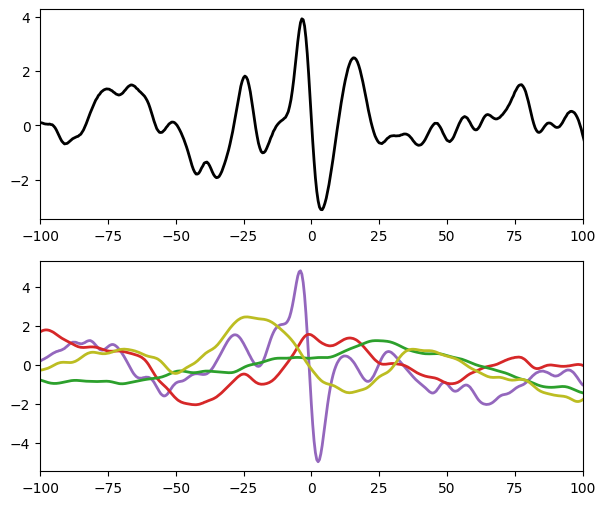

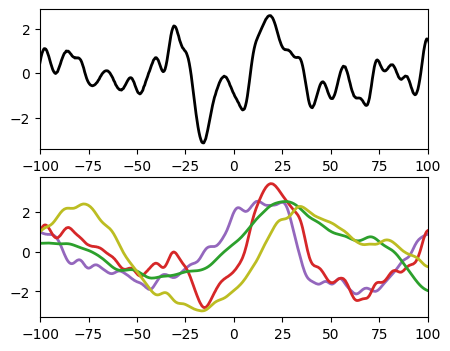

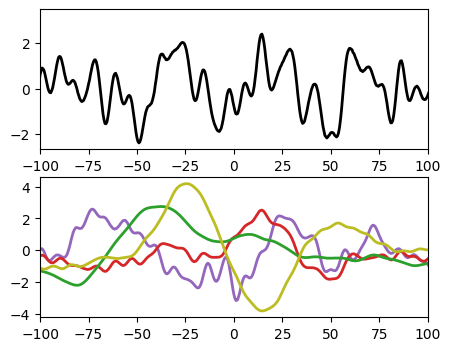

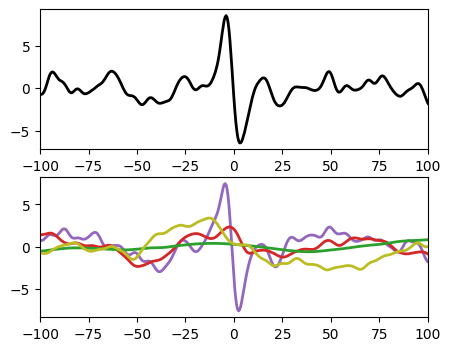

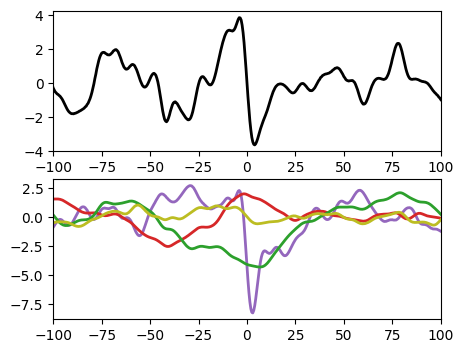

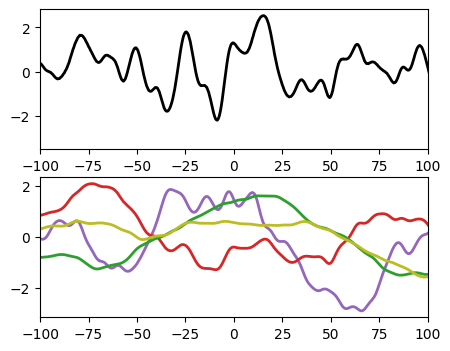

In [12]:
fig = plt.figure(figsize=(7,6))
gs = fig.add_gridspec(nrows=2, ncols=1)

ax  = np.array([
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[1,0]),
    ])
ax[0].plot(rv, CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2))), c='k', lw=2)

ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_CH4.sum(axis=(1,2))), c='C4', lw=2)
ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_H2O.sum(axis=(1,2))), c='C3', lw=2)
#ax[1].plot(rv, CCF_eq_band_CH4.sum(axis=(1,2))+CCF_eq_band_H2O.sum(axis=(1,2)), c='C1', lw=2)

ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_CO.sum(axis=(1,2))), c='C2', lw=2)
ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_NH3.sum(axis=(1,2))), c='C8', lw=2)

for ax_i in ax:
    ax_i.set(
        xlim=(-100, 100), 
        )

plt.show()

for i in [0,1,2,3,4]:
    fig = plt.figure(figsize=(5,4))
    gs = fig.add_gridspec(nrows=2, ncols=1)

    ax  = np.array([
        fig.add_subplot(gs[0,0]),
        fig.add_subplot(gs[1,0]),
        ])
    ax[0].plot(rv, CCF_to_SNR(rv, CCF_eq_band[:,[i]].sum(axis=(1,2))), c='k', lw=2)

    ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_CH4[:,[i]].sum(axis=(1,2))), c='C4', lw=2)
    ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_H2O[:,[i]].sum(axis=(1,2))), c='C3', lw=2)

    ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_CO[:,[i]].sum(axis=(1,2))), c='C2', lw=2)
    ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_NH3[:,[i]].sum(axis=(1,2))), c='C8', lw=2)

    for ax_i in ax:
        ax_i.set(
            xlim=(-100, 100), 
            )

    plt.show()

0.17811878563989483


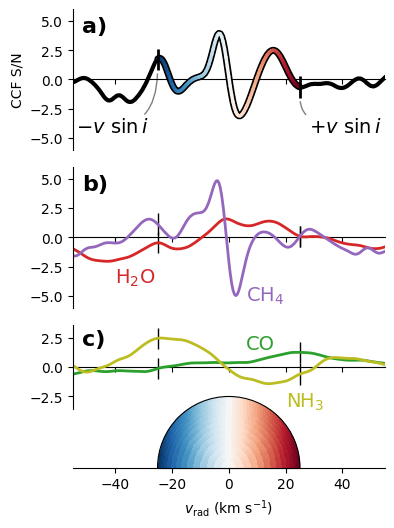

In [13]:
fig = plt.figure(figsize=(4,6*4/4.5))

gs = fig.add_gridspec(nrows=3, ncols=1, hspace=0.14, height_ratios=[1,1,0.6])
ax = np.array([
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[1,0]),
    fig.add_subplot(gs[2,0]),
    #fig.add_subplot(gs[3,0]),
    ])


ax[0].plot(rv, CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2))), c='k', lw=3)
rv_mask = (np.abs(rv) < vsini_eq_band)
ax[0].plot(
    rv[rv_mask], CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2)))[rv_mask], 
    c='k', lw=5, solid_capstyle='round'
    )
f.plot_multicolor_line(
    ax[0], rv[rv_mask], CCF_to_SNR(rv, CCF_eq_band.sum(axis=(1,2)))[rv_mask], 
    rv[rv_mask], cmap='RdBu_r', lw=2.5, vmin=-vsini_eq_band, vmax=vsini_eq_band
    )

ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_H2O.sum(axis=(1,2))), c='C3', lw=2)
ax[1].plot(rv, CCF_to_SNR(rv, CCF_eq_band_CH4.sum(axis=(1,2))), c='C4', lw=2)

ax[2].plot(rv, CCF_to_SNR(rv, CCF_eq_band_CO.sum(axis=(1,2))), c='C2', lw=2)
ax[2].plot(rv, CCF_to_SNR(rv, CCF_eq_band_NH3.sum(axis=(1,2))), c='C8', lw=2)

#ylim = [ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim(), None]
#ymin = np.min([ax_i.get_ylim()[0] for ax_i in ax])
#ymax = np.max([ax_i.get_ylim()[1] for ax_i in ax])
#print(ylim, ymin, ymax)

h_ratio_10 = gs.get_height_ratios()[1]/gs.get_height_ratios()[0]
h_ratio_20 = gs.get_height_ratios()[2]/gs.get_height_ratios()[0]
#ylim = [(-6*h_ratio_01,12*h_ratio_01), (-11,7), (-9*h_ratio_21,9*h_ratio_21), None]
#ylim = [(-6*h_ratio_01,12*h_ratio_01), (-6,5), (-9*h_ratio_21,9*h_ratio_21), None]
ylim = [(-6,6), (-6*h_ratio_10,6*h_ratio_10), (-6*h_ratio_20,6*h_ratio_20), None]

for i, ax_i in enumerate(ax):
    #ax_i.set(xlim=(-85,85), ylim=ylim[i])
    ax_i.set(xlim=(-55,55), ylim=ylim[i])
    #ax_i.set(ylim=ylim[i])
    #ax_i.set_xticks([-75,-50,-25,0,25,50,75] + [-vsini_eq_band,vsini_eq_band])
    #ax_i.set_xticks([-75,-50,-25,0,25,50,75])

    ax_i.spines[['top','right']].set_visible(False)
    ax_i.set_facecolor('none')

    for j, line_j in enumerate(ax_i.get_lines()):
        x, y = line_j.get_xydata().T
        y1, y2 = np.interp([-vsini_eq_band,vsini_eq_band], x, y)        
        yerr = 0.9

        elinewidth = 1; zorder = -1
        if i == 0:
            elinewidth = 2; zorder = None
            if j > 0:
                continue
            arrowprops = {
                'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=90', 
                'shrinkA':0, 'shrinkB':3, 'lw':1, 'color':'k', 'alpha':0.5, 
                }
            ax_i.annotate(
                r'$-v\ \sin{i}$', xy=(-vsini_eq_band,y1-yerr), xytext=(-vsini_eq_band-3,-3.2), 
                ha='right', va='top', fontsize=14, arrowprops=arrowprops
                )
            ax_i.annotate(
                r'$+v\ \sin{i}$', xy=(vsini_eq_band,y2-yerr), xytext=(+vsini_eq_band+3,-3.2), 
                ha='left', va='top', fontsize=14, arrowprops=arrowprops
                )
            
        ax_i.errorbar(
            [-vsini_eq_band,vsini_eq_band], [y1,y2], yerr=yerr, 
            ls='', elinewidth=elinewidth, ecolor='k', zorder=zorder
            #ecolor=line_j.get_color(), #ecolor='k'
            )
        
    ax_i.spines[['bottom']].set_position('zero')
    ax_i.set(xticklabels=[])
    ax_i.spines[['bottom']].set_zorder(-1)

ax[0].set(ylabel=r'CCF S/N')

ax[1].annotate(r'CH$_4$', xy=(6,-5), ha='left', va='center', fontsize=14, color='C4')
ax[1].annotate(r'H$_2$O', xy=(-40,-2.5), ha='left', va='top', fontsize=14, color='C3')

ax[2].annotate(r'CO', xy=(6,2), ha='left', va='center', fontsize=14, color='C2')
ax[2].annotate(r'NH$_3$', xy=(20,-2), ha='left', va='top', fontsize=14, color='C8')

plt.subplots_adjust(left=0.18, bottom=0.21, top=0.96, right=0.96)

l, b, w, h = ax[2].get_position().bounds
ax_x = fig.add_axes([l,b-0.11,w,h], zorder=-1)
ax_x.spines[['left','top','right']].set_visible(False)
ax_x.set(
    xlim=ax[-1].get_xlim(), yticks=[], ylim=(0,1), 
    xlabel=r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$', 
    )

w_vsini = fig.transFigure.inverted().transform(ax[0].transData.transform((vsini_eq_band,0)))[0] - \
    fig.transFigure.inverted().transform(ax[0].transData.transform((-vsini_eq_band,0)))[0]

l, b, w, h = ax[0].get_position().bounds
l, b, w, h = ax_x.get_position().bounds
ax_vsini = fig.add_axes([l+w/2-w_vsini/2,b,w_vsini,w_vsini], projection='polar', zorder=-1)
print(w_vsini/2)

vmin, vmax = -vsini_eq_band, vsini_eq_band
f.plot_map(ax_vsini, 'v_grid', Rot_eq_band, cmap='RdBu_r', vmin=vmin, vmax=vmax)
f.set_axis(ax_vsini, Rot_eq_band, grid=False)
f.set_thetalim(ax_vsini, np.pi/2, np.pi)
ax_vsini.get_position()

dy = fig.transFigure.inverted().transform(ax_x.transData.transform((0,0)))[1] - \
    fig.transFigure.inverted().transform(ax_vsini.transData.transform((0,0)))[1]

l, b, w, h = ax_vsini.get_position().bounds
ax_vsini.set_position([l,b+dy,w,h])

#ax[0].a
font_kwargs = dict(fontsize=16, fontweight='bold')
ax[0].annotate('a)', xy=(0.03,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)
ax[1].annotate('b)', xy=(0.03,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)
ax[2].annotate('c)', xy=(0.03,0.95), xycoords='axes fraction', ha='left', va='top', **font_kwargs)

#fig.savefig('./plots/local_chem_CCF.pdf')
fig.savefig('./plots/local_chem_CCF_B.pdf')
#fig.savefig('./plots/local_chem_CCF_A.pdf')
plt.show()

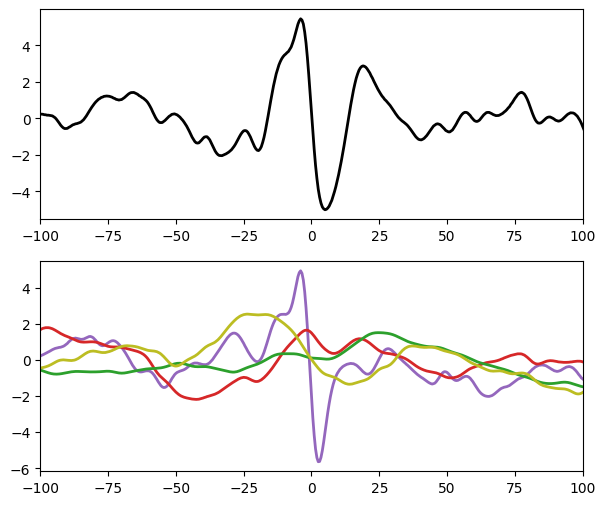

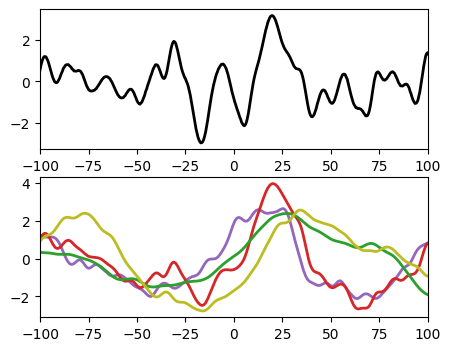

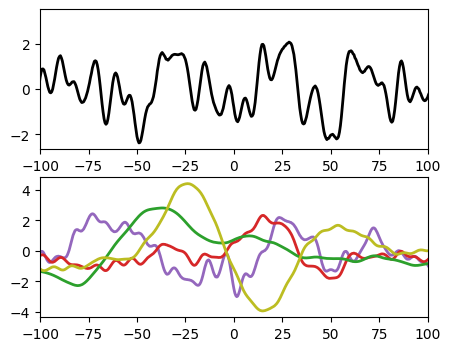

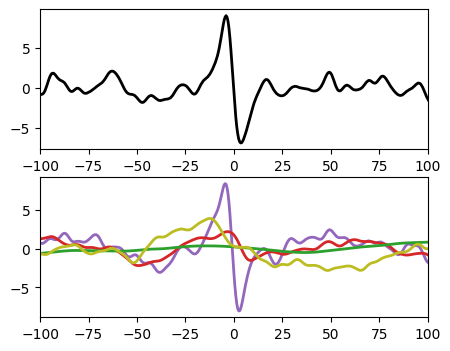

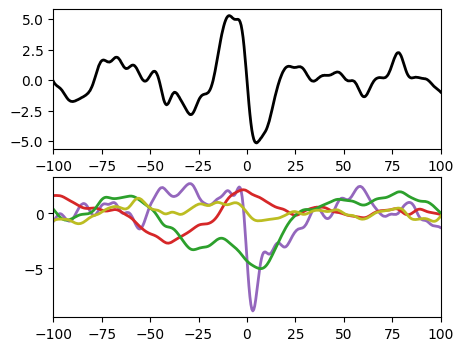

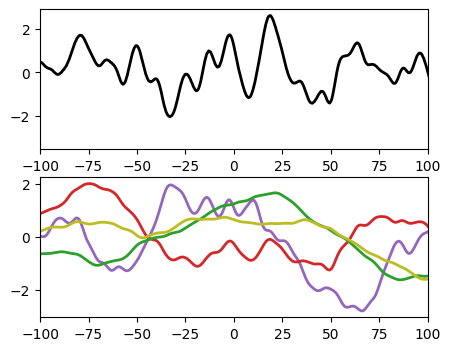

In [14]:
fig = plt.figure(figsize=(7,6))
gs = fig.add_gridspec(nrows=2, ncols=1)

ax  = np.array([
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[1,0]),
    ])
ax[0].plot(rv, CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2))), c='k', lw=2)

ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_CH4.sum(axis=(1,2))), c='C4', lw=2)
ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_H2O.sum(axis=(1,2))), c='C3', lw=2)
#ax[1].plot(rv, CCF_no_band_CH4.sum(axis=(1,2))+CCF_no_band_H2O.sum(axis=(1,2)), c='C1', lw=2)

ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_CO.sum(axis=(1,2))), c='C2', lw=2)
ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_NH3.sum(axis=(1,2))), c='C8', lw=2)

for ax_i in ax:
    ax_i.set(
        xlim=(-100, 100), 
        )

plt.show()

for i in [0,1,2,3,4]:
    fig = plt.figure(figsize=(5,4))
    gs = fig.add_gridspec(nrows=2, ncols=1)

    ax  = np.array([
        fig.add_subplot(gs[0,0]),
        fig.add_subplot(gs[1,0]),
        ])
    ax[0].plot(rv, CCF_to_SNR(rv, CCF_no_band[:,[i]].sum(axis=(1,2))), c='k', lw=2)

    ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_CH4[:,[i]].sum(axis=(1,2))), c='C4', lw=2)
    ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_H2O[:,[i]].sum(axis=(1,2))), c='C3', lw=2)

    ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_CO[:,[i]].sum(axis=(1,2))), c='C2', lw=2)
    ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_NH3[:,[i]].sum(axis=(1,2))), c='C8', lw=2)

    for ax_i in ax:
        ax_i.set(
            xlim=(-100, 100), 
            )

    plt.show()

0.18744983544761365


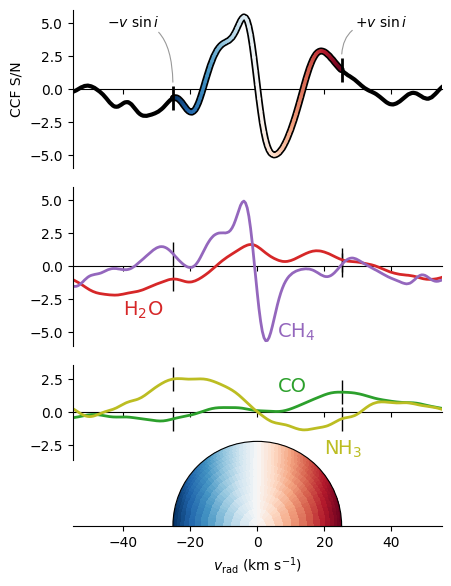

In [15]:
fig = plt.figure(figsize=(4.5,6))

gs = fig.add_gridspec(nrows=3, ncols=1, hspace=0.14, height_ratios=[1,1,0.6])
ax = np.array([
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[1,0]),
    fig.add_subplot(gs[2,0]),
    #fig.add_subplot(gs[3,0]),
    ])


ax[0].plot(rv, CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2))), c='k', lw=3)
rv_mask = (np.abs(rv) < vsini_no_band)
ax[0].plot(
    rv[rv_mask], CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2)))[rv_mask], 
    c='k', lw=5, solid_capstyle='round'
    )
f.plot_multicolor_line(
    ax[0], rv[rv_mask], CCF_to_SNR(rv, CCF_no_band.sum(axis=(1,2)))[rv_mask], 
    rv[rv_mask], cmap='RdBu_r', lw=2.5, vmin=-vsini_no_band, vmax=vsini_no_band
    )

ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_H2O.sum(axis=(1,2))), c='C3', lw=2)
ax[1].plot(rv, CCF_to_SNR(rv, CCF_no_band_CH4.sum(axis=(1,2))), c='C4', lw=2)

ax[2].plot(rv, CCF_to_SNR(rv, CCF_no_band_CO.sum(axis=(1,2))), c='C2', lw=2)
ax[2].plot(rv, CCF_to_SNR(rv, CCF_no_band_NH3.sum(axis=(1,2))), c='C8', lw=2)

#ylim = [ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim(), None]
#ymin = np.min([ax_i.get_ylim()[0] for ax_i in ax])
#ymax = np.max([ax_i.get_ylim()[1] for ax_i in ax])
#print(ylim, ymin, ymax)

h_ratio_10 = gs.get_height_ratios()[1]/gs.get_height_ratios()[0]
h_ratio_20 = gs.get_height_ratios()[2]/gs.get_height_ratios()[0]
#ylim = [(-6*h_ratio_01,12*h_ratio_01), (-11,7), (-9*h_ratio_21,9*h_ratio_21), None]
#ylim = [(-6*h_ratio_01,12*h_ratio_01), (-6,5), (-9*h_ratio_21,9*h_ratio_21), None]
ylim = [(-6,6), (-6*h_ratio_10,6*h_ratio_10), (-6*h_ratio_20,6*h_ratio_20), None]

for i, ax_i in enumerate(ax):
    #ax_i.set(xlim=(-85,85), ylim=ylim[i])
    ax_i.set(xlim=(-55,55), ylim=ylim[i])
    #ax_i.set(ylim=ylim[i])
    #ax_i.set_xticks([-75,-50,-25,0,25,50,75] + [-vsini_no_band,vsini_no_band])
    #ax_i.set_xticks([-75,-50,-25,0,25,50,75])

    ax_i.spines[['top','right']].set_visible(False)
    ax_i.set_facecolor('none')

    for j, line_j in enumerate(ax_i.get_lines()):
        x, y = line_j.get_xydata().T
        y1, y2 = np.interp([-vsini_no_band,vsini_no_band], x, y)        
        yerr = 0.9

        elinewidth = 1; zorder = -1
        if i == 0:
            elinewidth = 2; zorder = None
            if j > 0:
                continue
            ax_i.annotate(
                r'$-v\ \sin{i}$', xy=(-vsini_no_band,y1+yerr), xytext=(-vsini_no_band-4,4.5), 
                ha='right', va='bottom', arrowprops={
                    'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=90', 
                    'shrinkA':0, 'shrinkB':3, #'arrowstyle':']-',
                    'lw':0.8, 'color':'k', 'alpha':0.4, 
                    }
                )
            ax_i.annotate(
                r'$+v\ \sin{i}$', xy=(vsini_no_band,y2+yerr), xytext=(+vsini_no_band+4,4.5), 
                ha='left', va='bottom', arrowprops={
                    'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=90', 
                    'shrinkA':0, 'shrinkB':3, #'arrowstyle':']-',
                    'lw':0.8, 'color':'k', 'alpha':0.4, 
                    }
                )
            
        ax_i.errorbar(
            [-vsini_no_band,vsini_no_band], [y1,y2], yerr=yerr, 
            ls='', elinewidth=elinewidth, ecolor='k', zorder=zorder
            #ecolor=line_j.get_color(), #ecolor='k'
            )
        
    ax_i.spines[['bottom']].set_position('zero')
    ax_i.set(xticklabels=[])
    ax_i.spines[['bottom']].set_zorder(-1)

ax[0].set(ylabel=r'CCF S/N')

ax[1].annotate(r'CH$_4$', xy=(6,-5), ha='left', va='center', fontsize=14, color='C4')
ax[1].annotate(r'H$_2$O', xy=(-40,-2.5), ha='left', va='top', fontsize=14, color='C3')

ax[2].annotate(r'CO', xy=(6,2), ha='left', va='center', fontsize=14, color='C2')
ax[2].annotate(r'NH$_3$', xy=(20,-2), ha='left', va='top', fontsize=14, color='C8')

plt.subplots_adjust(left=0.14, bottom=0.21, top=0.96, right=0.96)

l, b, w, h = ax[2].get_position().bounds
ax_x = fig.add_axes([l,b-0.11,w,h], zorder=-1)
ax_x.spines[['left','top','right']].set_visible(False)
ax_x.set(
    xlim=ax[-1].get_xlim(), yticks=[], ylim=(0,1), 
    xlabel=r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$', 
    )

w_vsini = fig.transFigure.inverted().transform(ax[0].transData.transform((vsini_no_band,0)))[0] - \
    fig.transFigure.inverted().transform(ax[0].transData.transform((-vsini_no_band,0)))[0]

l, b, w, h = ax[0].get_position().bounds
l, b, w, h = ax_x.get_position().bounds
ax_vsini = fig.add_axes([l+w/2-w_vsini/2,b,w_vsini,w_vsini], projection='polar', zorder=-1)
print(w_vsini/2)

vmin, vmax = -vsini_no_band, vsini_no_band
f.plot_map(ax_vsini, 'v_grid', Rot_no_band, cmap='RdBu_r', vmin=vmin, vmax=vmax)
f.set_axis(ax_vsini, Rot_no_band, grid=False)
f.set_thetalim(ax_vsini, np.pi/2, np.pi)
ax_vsini.get_position()

dy = fig.transFigure.inverted().transform(ax_x.transData.transform((0,0)))[1] - \
    fig.transFigure.inverted().transform(ax_vsini.transData.transform((0,0)))[1]

l, b, w, h = ax_vsini.get_position().bounds
ax_vsini.set_position([l,b+dy,w,h])

#fig.savefig('./plots/local_chem_CCF.pdf')
fig.savefig('./plots/local_chem_CCF_B_elliptical_spot_1model.pdf')
#fig.savefig('./plots/local_chem_CCF_A.pdf')
plt.show()